In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from afqinsight.nn.utils import prep_fa_dataset, reconstruction_loss, vae_loss, kl_divergence_loss, prep_first_tract_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
import pandas as pd
import seaborn as sns
from afqinsight.nn.pt_models import VariationalAutoencoder



/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# FIRST TRACT DATASET
# NON VARIATIONAL 
# FC
# TESTING LATENT

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [4]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [5]:
torch_dataset, first_tract_train_loader, first_tract_test_loader, first_tract_val_loader = prep_first_tract_data(
    dataset, batch_size=64
)

In [22]:
def train_variational_autoencoder_widescope(model, train_data, val_data, epochs=500, lr=0.001, kl_weight=0.001):
    """
    Training loop for variational autoencoder with KL annealing
    """
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    train_kl_per_epoch = []
    val_kl_per_epoch = []
    train_recon_per_epoch = []
    val_recon_per_epoch = []
    
    best_val_rmse = float('inf')  # Track the best (lowest) validation RMSE
    best_model_state = None  # Save the best model state

    #lets try KL annealing
    beta_start = 0.0
    beta_end = 1.0
    slope = (beta_end - beta_start) / epochs
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0
        running_rmse = 0
        running_kl = 0
        items = 0
        running_recon_loss = 0 
        beta = beta_start + slope * epoch
        
        for x, _ in train_data:
            batch_size = x.size(0)
            tract_data = x.to(device)
            
            opt.zero_grad()
            
            # Forward pass returns reconstructed x, mean and logvar
            x_hat, mean, logvar = model(tract_data)
            
            # Compute loss with KL divergence
            loss, recon_loss, kl_loss = vae_loss(tract_data, x_hat, mean, logvar, beta, reduction="sum")
            #recon loss here is the sum of the MSE
            #loss is the sum of the KL and the recon loss
            #kl loss is the sum of the KL
            #none are normalized yet 

            # Calculate RMSE (primarily for logging)
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
            
            loss.backward()
            opt.step()
              
            #increasing by batch size
            items += batch_size
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * batch_size  # Weighted sum
            running_kl += kl_loss.item() # Average KL per item
            running_recon_loss += recon_loss.item() # Average recon loss per item
        
        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        avg_train_kl = running_kl / items 
        avg_train_recon_loss = running_recon_loss / items
        train_rmse_per_epoch.append(avg_train_rmse)
        train_kl_per_epoch.append(avg_train_kl)
        train_recon_per_epoch.append(avg_train_recon_loss)

        # Validation
        model.eval()
        val_rmse = 0
        val_kl = 0
        val_items = 0
        val_recon_loss = 0
        
        with torch.no_grad():
            for x, *_ in val_data:
                batch_size = x.size(0)
                tract_data = x.to(device)

                x_hat, mean, logvar = model(tract_data)
                
                val_loss, val_recon_loss, val_kl_loss = vae_loss(tract_data, x_hat, mean, logvar, beta, reduction="sum")
                
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += batch_size
                val_loss += val_loss.item()
                val_rmse += batch_val_rmse.item() * tract_data.size(0)
                val_kl += val_kl_loss.item()
                val_recon_loss += val_recon_loss.item()
        
        avg_val_recon_loss = val_recon_loss / val_items
        avg_val_rmse = val_rmse / val_items
        avg_val_kl = val_kl / val_items
        val_rmse_per_epoch.append(avg_val_rmse)
        val_kl_per_epoch.append(avg_val_kl)
        val_recon_per_epoch.append(avg_val_recon_loss)
        
        # Check and save the best model state if current validation loss is lower
        if avg_val_rmse < best_val_rmse:
            print("Saving best model state with RMSE:", avg_val_rmse)
            best_val_rmse = avg_val_rmse
            best_model_state = model.state_dict().copy()  # Make a copy to ensure it's preserved
        
        print(f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}, KL: {avg_train_kl:.4f}," ,
              f"Recon Loss (Train): {avg_train_recon_loss:.4f}, Recon Loss (Val): {avg_val_recon_loss:.4f}")
    
    # Load the best model state back into the model
    model.load_state_dict(best_model_state)
    
    return {
        "train_rmse_per_epoch": train_rmse_per_epoch,
        "val_rmse_per_epoch": val_rmse_per_epoch,
        "train_kl_per_epoch": train_kl_per_epoch,
        "val_kl_per_epoch": val_kl_per_epoch,
        "train_recon_per_epoch": train_recon_per_epoch,
        "val_recon_per_epoch": val_recon_per_epoch,
        "best_val_rmse": best_val_rmse,
    }

In [23]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
models = {}
results = {}

for latent_dim in latent_dims:
    print(f"Training Autoencoder with Latent Dimension: {latent_dim}")
    
    # Initialize a new autoencoder for each latent dimension
    test_model = VariationalAutoencoder(input_shape=100, latent_dims=latent_dim, dropout=0.0).to(device)
    
    # Train the model 
    training_results = train_variational_autoencoder_widescope(test_model, first_tract_train_loader, first_tract_val_loader, 100, 0.001)
    
    # Store both the model and results
    models[latent_dim] = test_model
    results[latent_dim] = training_results
    
    print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")


Training Autoencoder with Latent Dimension: 2
Saving best model state with RMSE: 0.31614103963143847
Epoch 1, Train RMSE: 0.4166, Val RMSE: 0.3161, KL: 0.1671, Recon Loss (Train): 17.6540, Recon Loss (Val): 2.6626
Saving best model state with RMSE: 0.15330592261309609
Epoch 2, Train RMSE: 0.2383, Val RMSE: 0.1533, KL: 0.7389, Recon Loss (Train): 5.9177, Recon Loss (Val): 0.7282
Saving best model state with RMSE: 0.07686700490007432
Epoch 3, Train RMSE: 0.1069, Val RMSE: 0.0769, KL: 2.0851, Recon Loss (Train): 1.1933, Recon Loss (Val): 0.1924
Saving best model state with RMSE: 0.059493477428238524
Epoch 4, Train RMSE: 0.0646, Val RMSE: 0.0595, KL: 3.0866, Recon Loss (Train): 0.4219, Recon Loss (Val): 0.1146
Saving best model state with RMSE: 0.0542341385497696
Epoch 5, Train RMSE: 0.0536, Val RMSE: 0.0542, KL: 3.6618, Recon Loss (Train): 0.2882, Recon Loss (Val): 0.0914
Saving best model state with RMSE: 0.05233896430270329
Epoch 6, Train RMSE: 0.0501, Val RMSE: 0.0523, KL: 3.9283, Reco

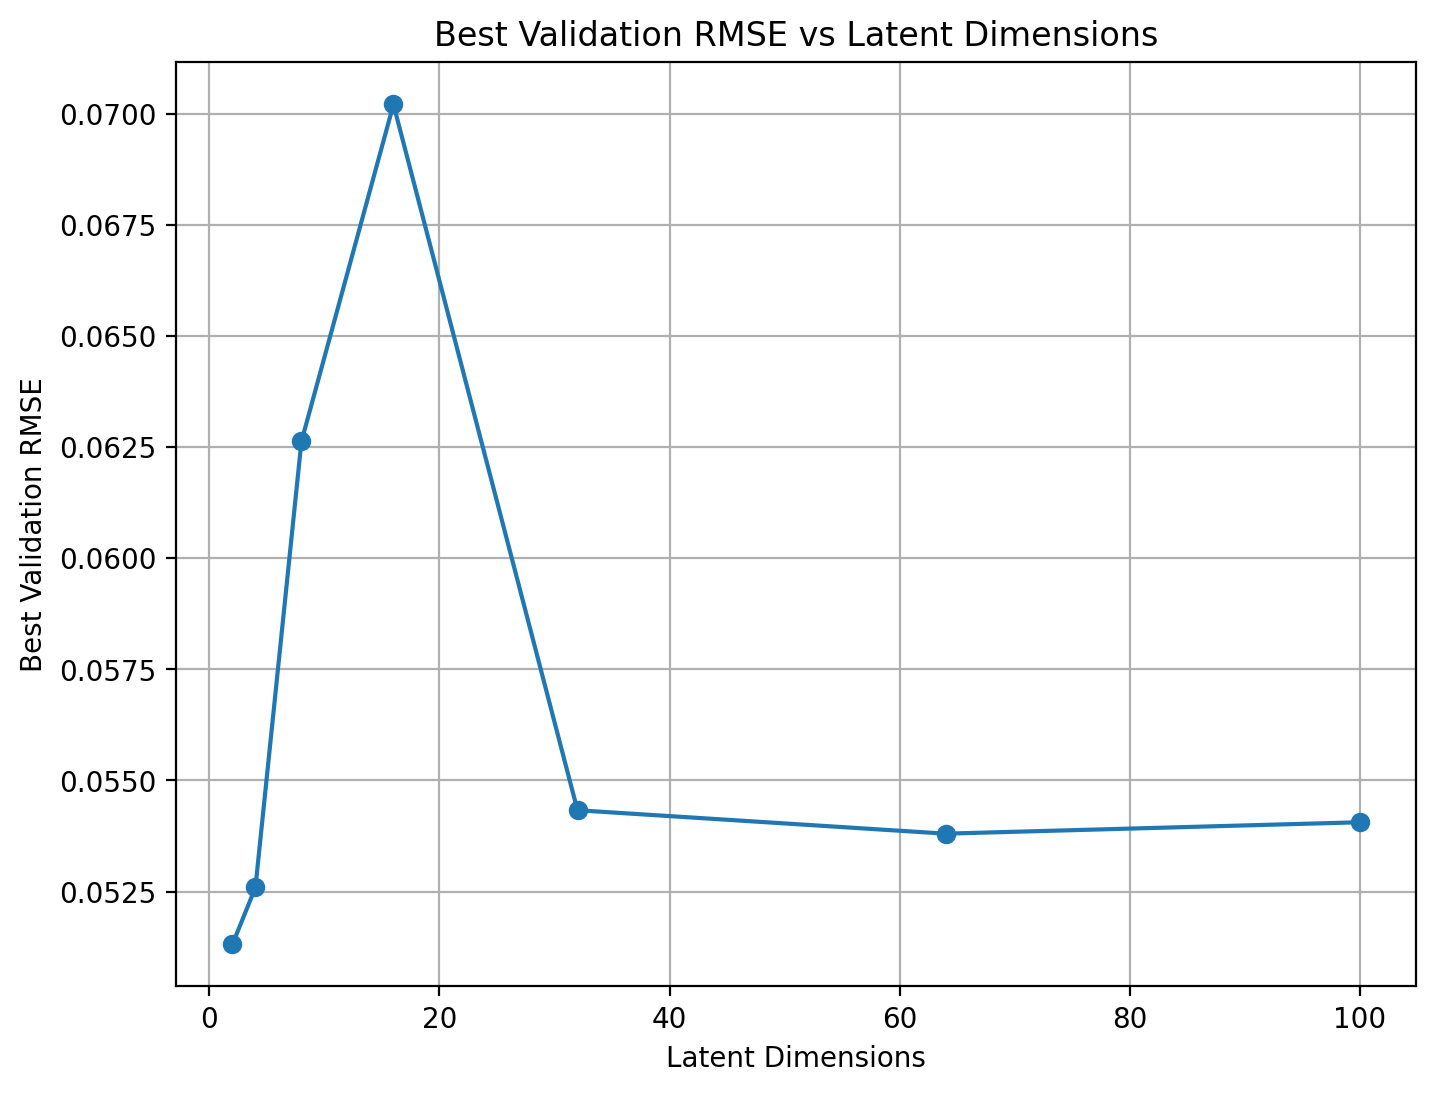

In [39]:
# Extract the latent dimensions and corresponding best validation RMSE values.
latent_dims_list = sorted(results.keys())
best_val_rmse = [results[dim]["best_val_rmse"] for dim in latent_dims_list]

plt.figure(figsize=(8, 6))
plt.plot(latent_dims_list, best_val_rmse, marker='o', linestyle='-')
plt.xlabel("Latent Dimensions")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs Latent Dimensions")
plt.grid(True)
plt.show()


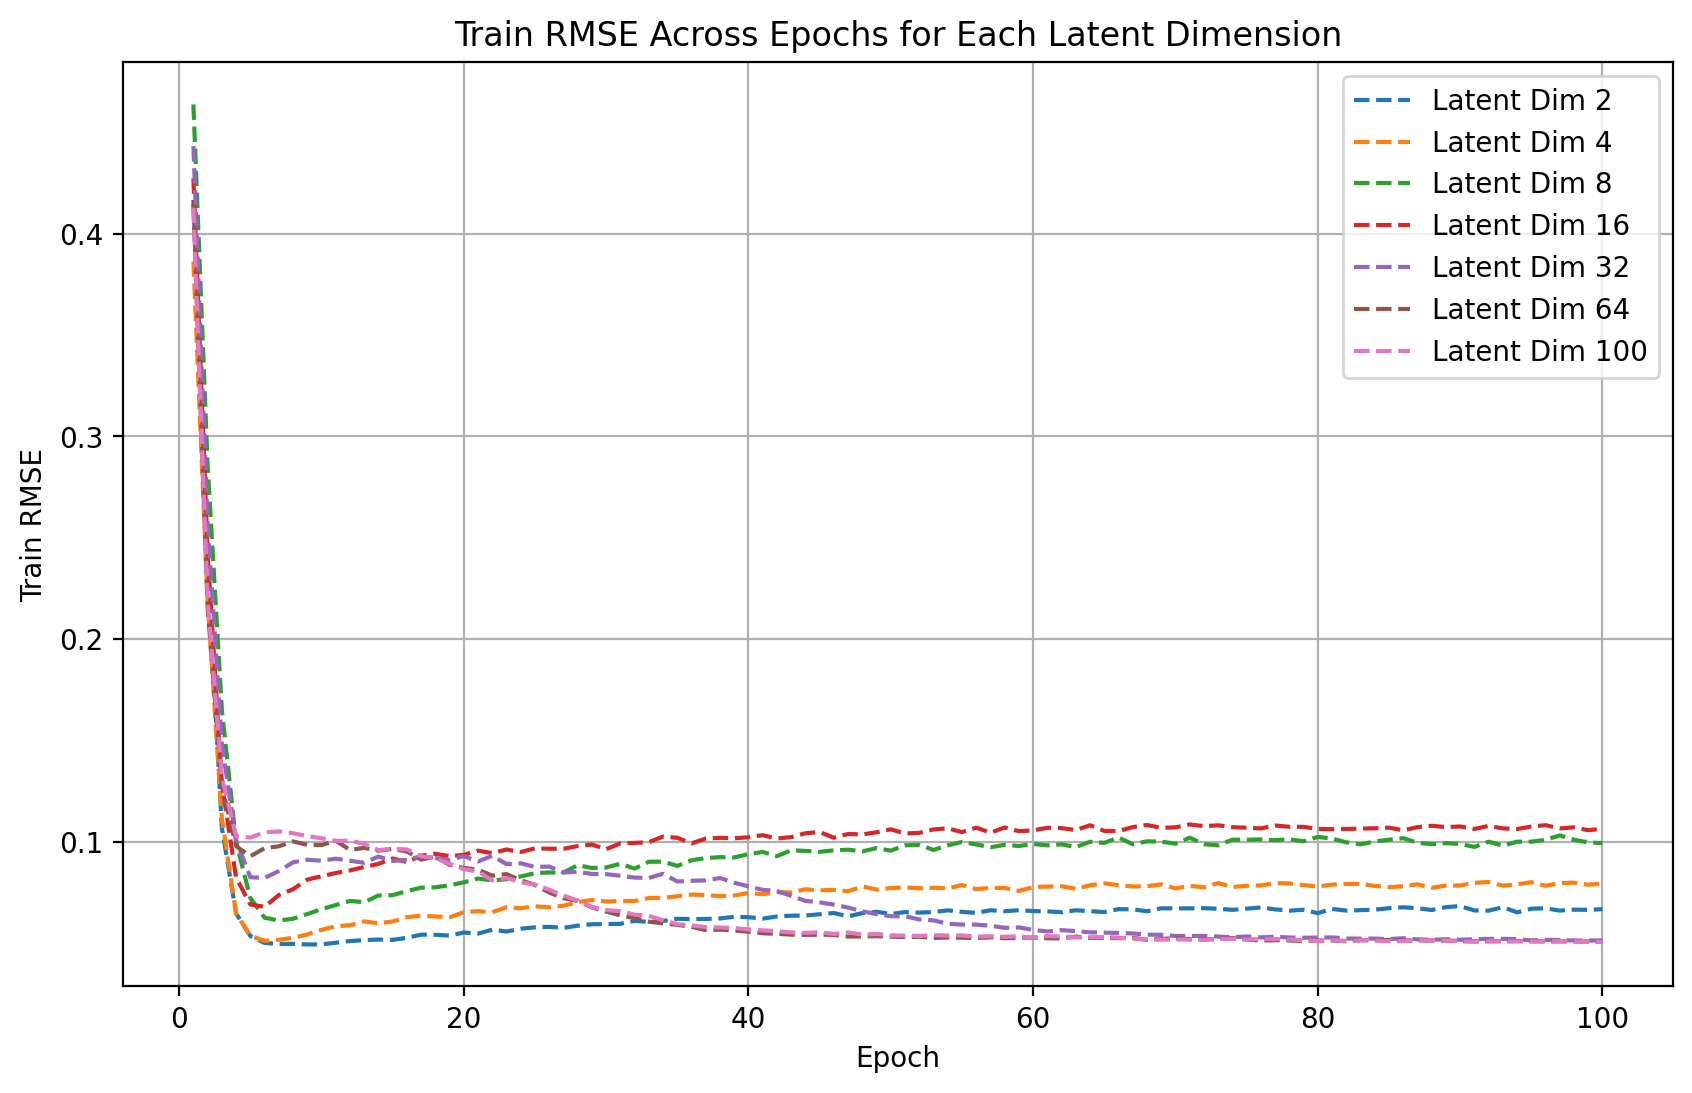

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Loop through each latent dimension in your results dictionary
for latent_dim, training_results in results.items():
    train_rmse = training_results["train_rmse_per_epoch"]
    epochs = range(1, len(train_rmse) + 1)
    plt.plot(epochs, train_rmse, linestyle='--', label=f"Latent Dim {latent_dim}")

plt.xlabel("Epoch")
plt.ylabel("Train RMSE")
plt.title("Train RMSE Across Epochs for Each Latent Dimension")
plt.legend()
plt.grid(True)
plt.show()


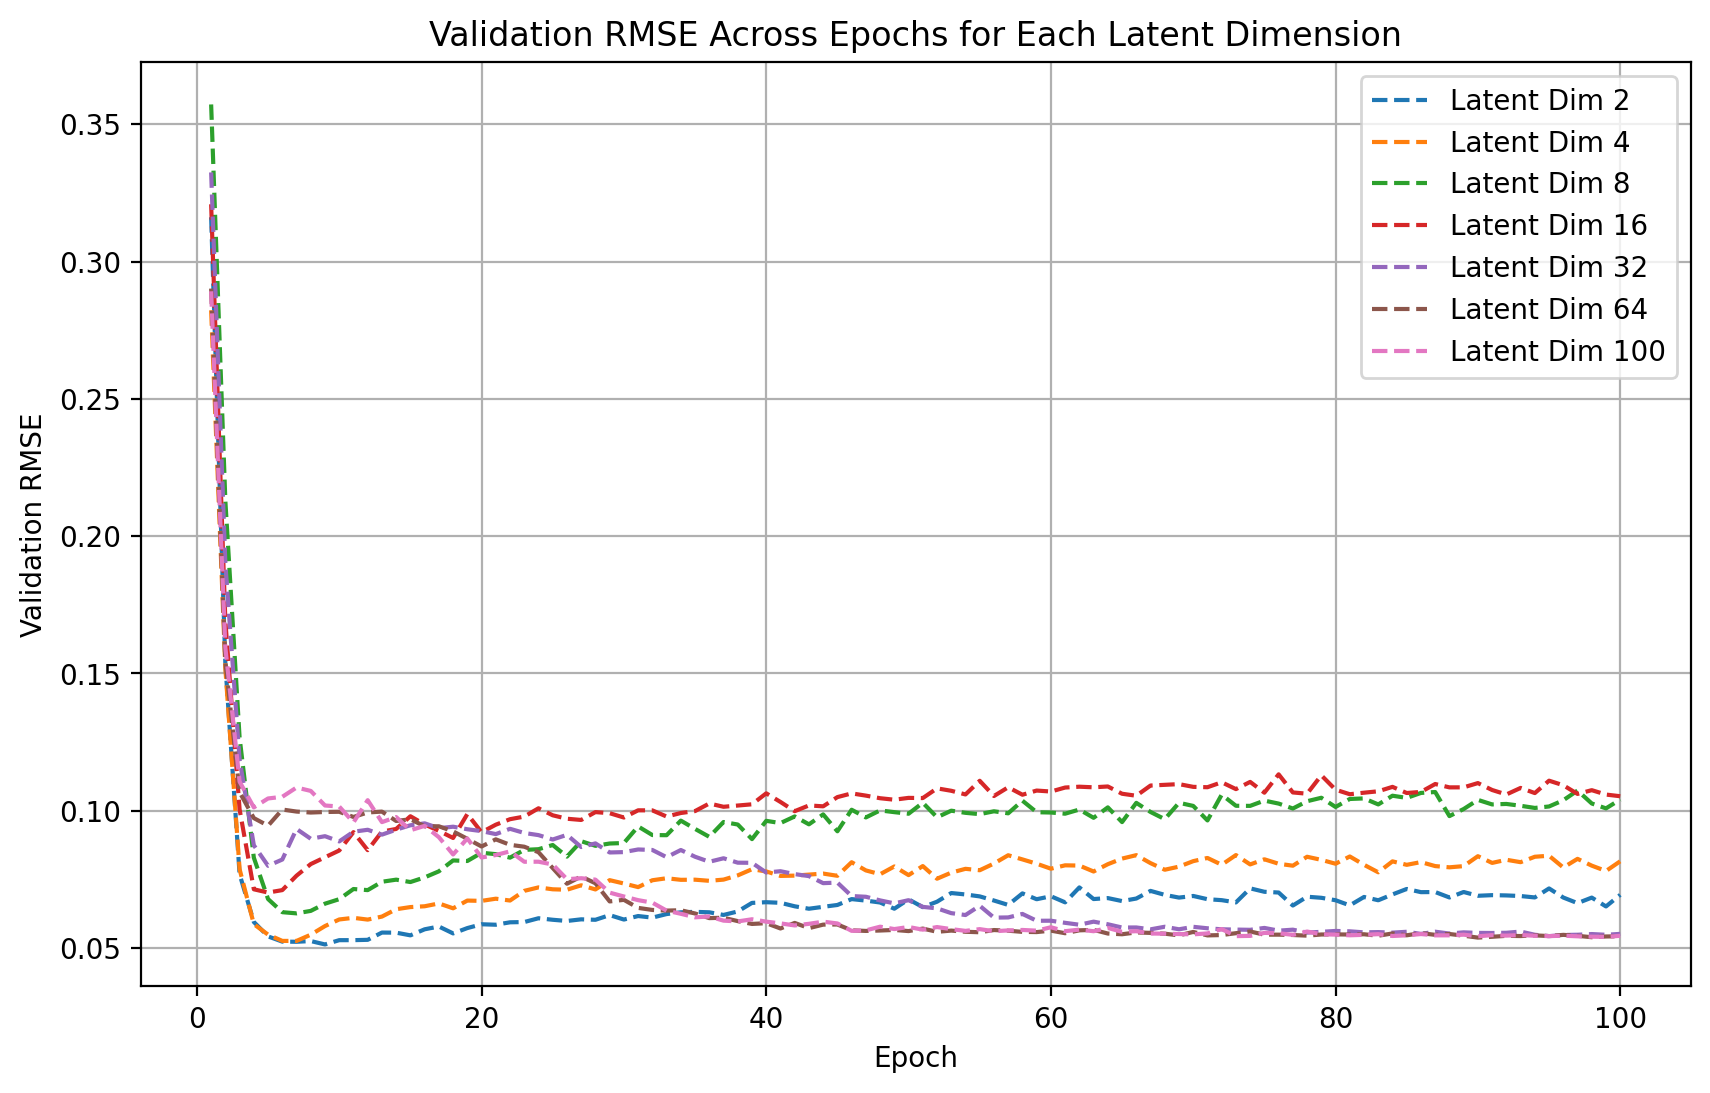

In [44]:
plt.figure(figsize=(10, 6))

# Loop through each latent dimension's results and plot the validation RMSE across epochs.
for latent_dim, training_results in results.items():
    val_rmse = training_results["val_rmse_per_epoch"]
    epochs = range(1, len(val_rmse) + 1)
    plt.plot(epochs, val_rmse, linestyle='--', label=f"Latent Dim {latent_dim}")

plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Across Epochs for Each Latent Dimension")
plt.legend()
plt.grid(True)
plt.show()

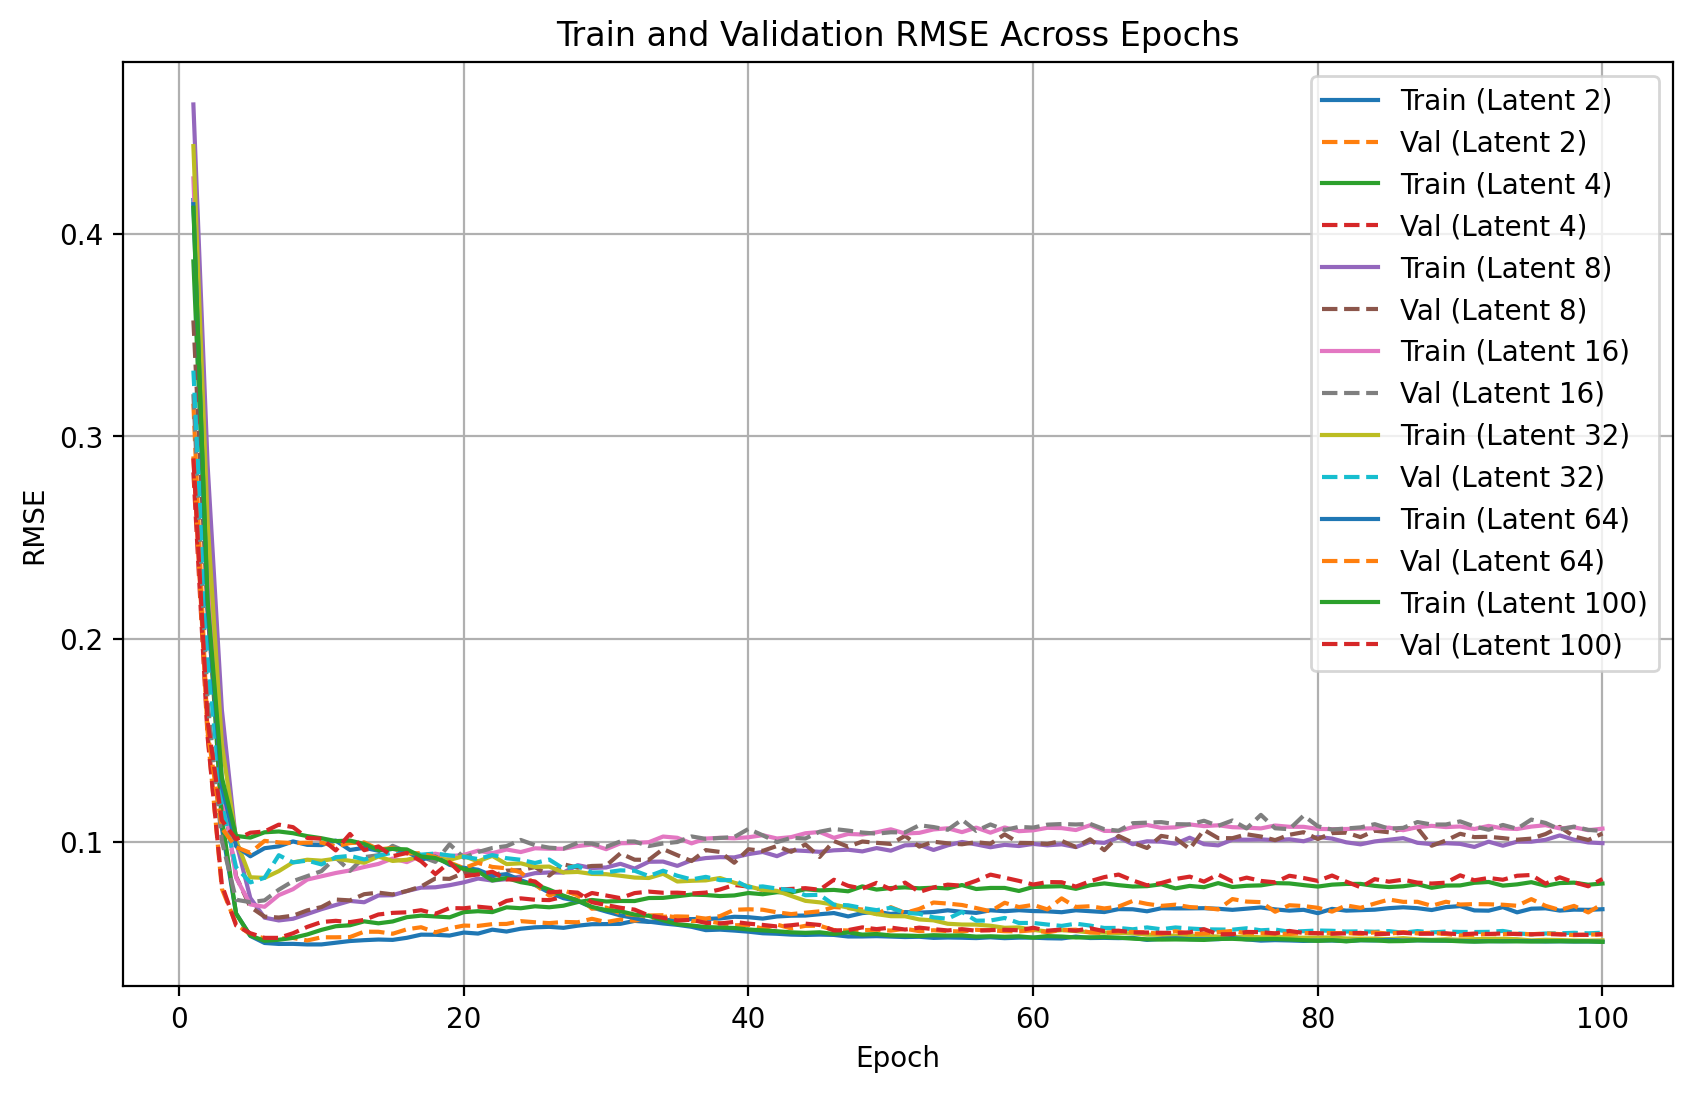

In [46]:
plt.figure(figsize=(10, 6))

# Loop through each latent dimension's results
for latent_dim, training_results in results.items():
    epochs = range(1, len(training_results["train_rmse_per_epoch"]) + 1)
    train_rmse = training_results["train_rmse_per_epoch"]
    val_rmse = training_results["val_rmse_per_epoch"]
    
    plt.plot(epochs, train_rmse, linestyle='-', label=f"Train (Latent {latent_dim})")
    plt.plot(epochs, val_rmse,linestyle='--', label=f"Val (Latent {latent_dim})")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train and Validation RMSE Across Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [91]:
#selecting the model with 64 latent dimensions
sample = test_loader.dataset[0][0][0:1].to(device)
output = models[64](sample)
print(sample.shape)

# Assuming the first element of the tuple is the reconstruction:
reconstructed = output[0]

orig = sample.cpu().detach().numpy()
recon = reconstructed.cpu().detach().numpy()


torch.Size([1, 100])


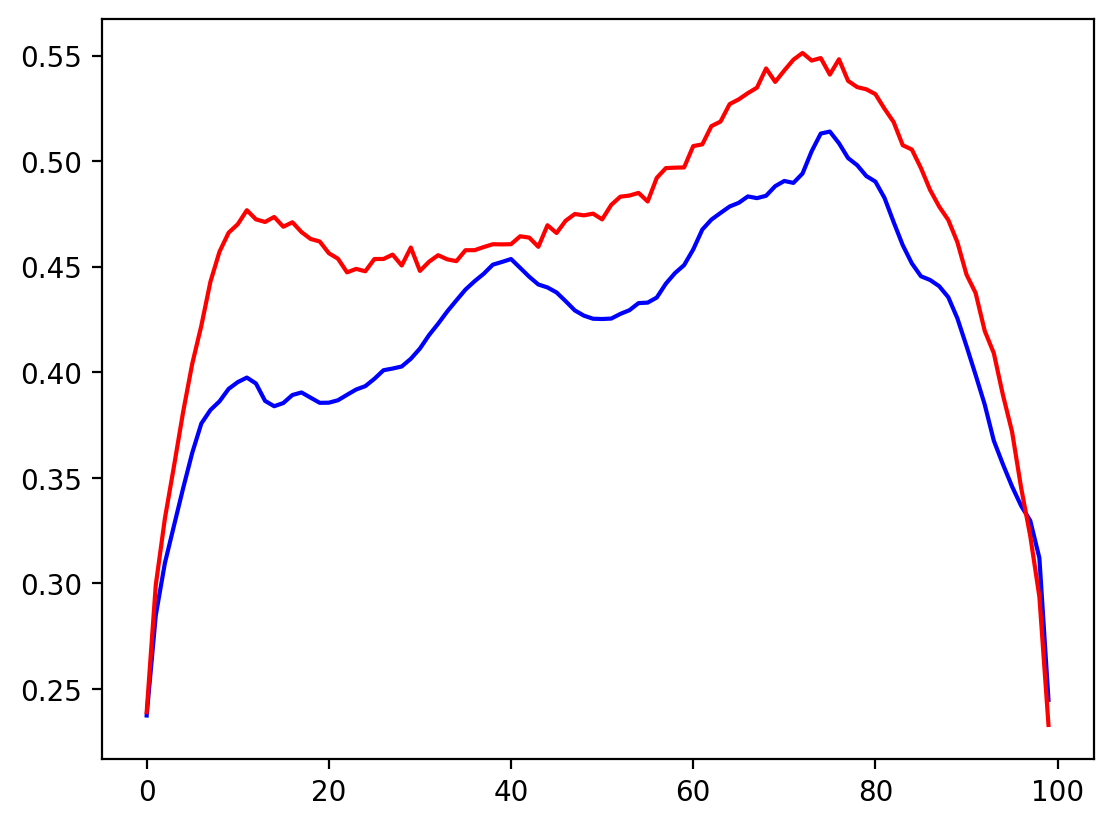

In [92]:
plt.plot(orig.flatten()[0:100], color='blue', label='Original')
plt.plot(recon.flatten()[0:100], color='red', label='Reconstructed')